# Training neural network force fields (NNFFs) with AMPtorch


Edited by N. Hu

Medford Research Group at Georgia Tech

Updated on 02/14/2022

This ipython notebook of training NNFFs is based on the BDQM-VIP lecture materials and the sample scripts provided by AMPtorch (`amptorch/example/`) for both conventional Symmetry Functions as finger-printing scheme + Behler-Parrnello atomistic neural network structure (2nd Generation NN), and Gaussian Multi-Pole + SingleNN neural network structure.

This paper introduces the basics and the formulation of Gaussian Multi-pole (GMP) descriptors: 
<https://arxiv.org/abs/2102.02390?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529>


# Table of contents
1. [Training with Symmetry Function and BPNN](#training_bp)
2. [Training with GMP and SingleNN](#training_gmp)

## Training on CuCO with Symmetry Functions + 2nd Gen NNFF <a name="training_bp"></a>

### Construct the training dataset

As an example, we calculate the potential energy and forces for CuCO chemical system with the EMT calculator implemented in ase. 

This step should be replaced with training datasets that have information on:
1. cell size
2. periodic boundary conditions
3. atomic positions
4. potential energy
5. forces, if doing force training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from ase import Atoms
import ase.io
from ase.calculators.emt import EMT
from ase.build import molecule


from amptorch.ase_utils import AMPtorch
from amptorch.trainer import AtomsTrainer

In [2]:
# get training images

distances = np.linspace(2, 5, 100)
images = []
for dist in distances:
    image = Atoms(
        "CuCO",
        [
            (-dist * np.sin(0.65), dist * np.cos(0.65), 0),
            (0, 0, 0),
            (dist * np.sin(0.65), dist * np.cos(0.65), 0),
        ],
    )
    image.set_cell([10, 10, 10])
    image.wrap(pbc=True)
    image.set_calculator(EMT())
    images.append(image)

### Define fingerprinting scheme

Here we demonstrate with the conventional Symmetry functions, $G^2$ and $G^4$. 

In [3]:
# define parameters for finger-printing scheme, Symmetry Function

Gs = {
    "default": {
        "G2": {
            "etas": np.logspace(np.log10(0.05), np.log10(5.0), num=4),
            "rs_s": [0],
        },
        "G4": {"etas": [0.005], "zetas": [1.0, 4.0], "gammas": [1.0, -1.0]},
        "cutoff": 6,
    },
}

### Define the configuration for trainer object

Detailed introductions and other specifications supported in trainer object can be found here under Section Usage/Configs: 
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb>

In [4]:
config = {
    "model": {
        "get_forces": True,
        "num_layers": 3,
        "num_nodes": 5,
        "batchnorm": True,
    },
    "optim": {
        "force_coefficient": 0.04,
        "lr": 1e-3,
        "batch_size": 32,
        "epochs": 10,
        "loss": "mse",
        "metric": "mae",
        "gpus": 0,
    },
    "dataset": {
        "raw_data": images,
        "fp_params": Gs,
        "save_fps": True,
        "scaling": {"type": "normalize", "range": (0, 1)},
        "val_split": 0,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        # Weights and Biases used for logging - an account(free) is required
        "logger": False,
    },
}

### Hit go and train

In [5]:
torch.set_num_threads(1)
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2022-02-14-18-48-47-test



Loading dataset: 100 images
Use Xavier initialization
Use Xavier initialization
Use Xavier initialization
Loading model: 1143 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_forces_mae    train_loss    cp     dur
-------  ------------------  ------------------  ------------  ----  ------
      1              0.9776              0.5535        1.0490     +  0.0410
      2              0.7315              0.5250        0.6843     +  0.0355
      3              0.5812              0.5261        0.4445     +  0.0353
      4              0.5395              0.5208        0.3698     +  0.0353
      5              0.5281              0.5250        0.5913     +  0.0354


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


      6              0.5183              0.5130        0.3640     +  0.0355
      7              0.5247              0.5123        0.3282        0.0352
      8              0.4966              0.5133        0.3748     +  0.0354
      9              0.4578              0.5022        0.3122     +  0.0352
     10              0.4195              0.4864        0.2077     +  0.0352
Training completed in 0.43488168716430664s


### Use the neural network as an ase calculator to make predictions

In [6]:
predictions = trainer.predict(images)

# assess errors

true_energies = np.array([image.get_potential_energy() for image in images])
pred_energies = np.array(predictions["energy"])

print("Energy MSE:", np.mean((true_energies - pred_energies) ** 2))
print("Energy MAE:", np.mean(np.abs(true_energies - pred_energies)))

images[0].set_calculator(AMPtorch(trainer))
images[0].get_potential_energy()

Energy MSE: 0.316875487045523
Energy MAE: 0.4133532974220065


10.200410481656832

## Training on 2D water dataset with GMP + SingleNN <a name="training_gmp"></a>

### Construct the training dataset

As an example of the training dataset, we calculate the potential energy and forces for 2-D single water potential energy surface. This dataset is calculated by Quantem Espresso (xc, PBE. kpts, (1,1,1). Planewave, 500.) One O-H bond length is fixed, and the other O-H length and the H-O-H bond angle are allowed to vary. 

Required information in the training datasets contains:
1. cell size
2. periodic boundary conditions
3. atomic positions
4. potential energy
5. forces, if doing force training

In [7]:
# get training images by reading trajectory files

# read all images from the trajectory
training = ase.io.read("./data/water_2d.traj", index=":")

# read every 10th image from the trajectory
# training = ase.io.read("./data/water_2d.traj", index="::10")

# print the length of the image
len(training)

400

In [8]:
# check the information

# cell size
print(training[0].get_cell())

# periodic boundary condition
print(training[0].get_pbc())

# atomic positions
print(training[0].get_positions())

# system potential energy
print(training[0].get_potential_energy())

# forces
print(training[0].get_forces())

# ase.Atoms object
print(training[0])

Cell([10.0, 10.0, 10.0])
[ True  True  True]
[[5.         4.82418565 5.2981545 ]
 [5.         5.58742465 4.7018455 ]
 [5.         4.41257535 4.77131852]]
-593.6701598080588
[[  0.          31.22263082  36.76981108]
 [  0.           1.73799984   1.01589577]
 [  0.         -32.96063066 -37.78570684]]
Atoms(symbols='OH2', pbc=True, cell=[10.0, 10.0, 10.0], calculator=SinglePointCalculator(...))


### Define fingerprinting scheme

Here we demonstrate with the GMP fingerprinting scheme. It requires the fitted pseduo-potentials of every elements. Access to the fitted pseduo-potentials:
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb/examples/GMP/valence_gaussians>

Like G2 and G4 symmetry functions, GMP uses $\sigma$'s in the radial coordinates and MCSH groups and orders in the angular coordinates.

In [9]:
# define sigmas
nsigmas = 10
sigmas = np.linspace(0, 2.0,nsigmas+1,endpoint=True)[1:]
print(sigmas)

# define MCSH orders
MCSHs_index = 2
MCSHs_dict = {
0: { "orders": [0], "sigmas": sigmas,},
1: { "orders": [0,1], "sigmas": sigmas,},
2: { "orders": [0,1,2], "sigmas": sigmas,},
3: { "orders": [0,1,2,3], "sigmas": sigmas,},
4: { "orders": [0,1,2,3,4], "sigmas": sigmas,},
5: { "orders": [0,1,2,3,4,5], "sigmas": sigmas,},
6: { "orders": [0,1,2,3,4,5,6], "sigmas": sigmas,},
7: { "orders": [0,1,2,3,4,5,6,7], "sigmas": sigmas,},
8: { "orders": [0,1,2,3,4,5,6,7,8], "sigmas": sigmas,},
9: { "orders": [0,1,2,3,4,5,6,7,8,9], "sigmas": sigmas,},
}
MCSHs = MCSHs_dict[MCSHs_index] # MCSHs is now just the order of MCSHs. 


GMP = {
    "MCSHs": MCSHs,
    "atom_gaussians": {
        "H": "./valence_gaussians/H_pseudodensity_2.g",
        "O": "./valence_gaussians/O_pseudodensity_4.g",
    },
    "cutoff": 12.0,
    "solid_harmonics": True,
}

elements = ["H", "O"]

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


### Define the configuration for trainer object

Detailed introductions and other specifications supported in trainer object can be found here under Section Usage/Configs: 
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb>

In [10]:
config = {
    "model": {
        "name":"singlenn",
        "get_forces": True,
        "num_layers": 3,
        "num_nodes": 10,
        "batchnorm": True,
        "activation":torch.nn.Tanh,
    },
    "optim": {
        "force_coefficient": 0.01,
        "lr": 1e-3,
        "batch_size": 16,
        "epochs": 500,
        "loss": "mse",
        "metric": "mae",
    },
    "dataset": {
        "raw_data": training,
        "fp_scheme": "gmpordernorm",
        "fp_params": GMP,
        "elements": elements,
        "save_fps": True,
        "scaling": {"type": "normalize", "range": (0, 1)},
        "val_split": 0.1,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        # Weights and Biases used for logging - an account(free) is required
        "logger": False,
    },
}

### Hit go and train

In [11]:
torch.set_num_threads(1)
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2022-02-14-18-48-51-test



Loading dataset: 400 images
Use Xavier initialization
Loading model: 601 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_forces_mae    train_loss    val_energy_mae    val_forces_mae    valid_loss    cp     dur
-------  ------------------  ------------------  ------------  ----------------  ----------------  ------------  ----  ------
      1              0.9166              3.6067        0.3347            1.0759            2.8713        0.4352     +  0.1192
      2              0.5748              3.2845        0.1749            0.4722            2.9645        0.1838     +  0.1186
      3              0.4819              3.1487        0.1435            0.3749            3.0119        0.1310     +  0.1183
      4              0.4268              3.0484        0.1212            0.3292            2.8507        0.1095     +  0.1183
      5              0.4574              2.9619        0.1221            0.3286            2.7766        0.1025     +  0.1187
      6   

     54              0.2247              1.2996        0.0221            0.1599            1.6260        0.0320        0.1176
     55              0.2060              1.3864        0.0232            0.1648            1.6399        0.0355        0.1175
     56              0.2332              1.3098        0.0235            0.1491            1.6725        0.0377        0.1176
     57              0.2238              1.3408        0.0232            0.1198            1.6988        0.0340     +  0.1186
     58              0.2219              1.3041        0.0224            0.2840            1.8580        0.0477        0.1187
     59              0.1922              1.2458        0.0197            0.1524            1.6290        0.0318        0.1184
     60              0.2528              1.2925        0.0267            0.1425            1.5187        0.0306        0.1182
     61              0.2082              1.2592        0.0226            0.1927            1.6108        0.0353       

    115              0.1359              0.8503        0.0085            0.1217            1.1843        0.0148        0.1186
    116              0.1621              0.9877        0.0120            0.1662            1.1458        0.0167        0.1187
    117              0.1623              0.8891        0.0117            0.1146            1.0696        0.0142        0.1177
    118              0.1661              0.9480        0.0122            0.1502            1.0151        0.0171        0.1182
    119              0.1595              0.8962        0.0189            0.1356            1.2482        0.0193        0.1181
    120              0.1535              0.9552        0.0122            0.1923            1.0914        0.0198        0.1182
    121              0.1450              0.8861        0.0106            0.1081            1.0266        0.0123        0.1181
    122              0.1509              0.9165        0.0112            0.1030            1.0825        0.0144       

    178              0.1218              0.6989        0.0067            0.0987            0.8368        0.0072        0.1179
    179              0.1247              0.6560        0.0073            0.0873            0.9423        0.0092        0.1188
    180              0.1160              0.6762        0.0060            0.1081            0.8068        0.0114        0.1188
    181              0.1199              0.7025        0.0080            0.0973            0.8420        0.0094        0.1179
    182              0.1038              0.6486        0.0052            0.1067            0.9095        0.0119        0.1186
    183              0.1378              0.7040        0.0074            0.1208            0.7002        0.0086        0.1189
    184              0.1296              0.6818        0.0077            0.0938            0.8172        0.0080        0.1186
    185              0.1400              0.7245        0.0085            0.1002            0.7333        0.0069       

    241              0.1086              0.5741        0.0049            0.0740            0.5500        0.0038        0.1195
    242              0.0894              0.5313        0.0040            0.0712            0.5655        0.0048        0.1196
    243              0.0925              0.5333        0.0036            0.0720            0.6282        0.0051        0.1193
    244              0.0958              0.5255        0.0039            0.0621            0.6408        0.0050        0.1186
    245              0.0816              0.5276        0.0034            0.0925            0.5871        0.0061        0.1188
    246              0.1015              0.5462        0.0047            0.0907            0.4786        0.0042        0.1192
    247              0.0986              0.5669        0.0043            0.0844            0.5655        0.0038        0.1179
    248              0.1024              0.5144        0.0068            0.0794            0.6536        0.0062       

    305              0.0846              0.4532        0.0028            0.0841            0.4653        0.0037        0.1203
    306              0.0762              0.4639        0.0027            0.0566            0.5069        0.0033        0.1204
    307              0.0717              0.4288        0.0025            0.0944            0.5556        0.0056        0.1180
    308              0.0801              0.4383        0.0028            0.0471            0.4951        0.0029     +  0.1191
    309              0.1036              0.4518        0.0043            0.1062            0.4879        0.0055        0.1195
    310              0.0974              0.5010        0.0040            0.0720            0.5052        0.0038        0.1181
    311              0.0929              0.4810        0.0038            0.0898            0.6897        0.0080        0.1182
    312              0.0929              0.4514        0.0034            0.0648            0.5299        0.0034       

    369              0.0835              0.4076        0.0027            0.0774            0.4522        0.0031        0.1191
    370              0.0791              0.4210        0.0027            0.0632            0.4395        0.0023        0.1192
    371              0.0713              0.3989        0.0023            0.0348            0.5196        0.0031     +  0.1195
    372              0.0708              0.3985        0.0022            0.0532            0.5302        0.0037        0.1190
    373              0.0959              0.4061        0.0035            0.0904            0.5035        0.0044        0.1190
    374              0.0767              0.4303        0.0027            0.0343            0.4582        0.0022     +  0.1204
    375              0.0775              0.4179        0.0027            0.0645            0.5720        0.0042        0.1193
    376              0.0881              0.4281        0.0032            0.0458            0.5657        0.0039       

    434              0.0832              0.3753        0.0025            0.0659            0.5373        0.0038        0.1207
    435              0.0730              0.3980        0.0024            0.0453            0.5193        0.0030        0.1194
    436              0.0781              0.3591        0.0022            0.0553            0.5149        0.0038        0.1184
    437              0.0742              0.3842        0.0023            0.0660            0.5185        0.0032        0.1195
    438              0.0704              0.3875        0.0022            0.0536            0.5182        0.0035        0.1196
    439              0.0718              0.3832        0.0022            0.0431            0.4709        0.0021        0.1185
    440              0.0735              0.3743        0.0022            0.0661            0.4632        0.0029        0.1194
    441              0.0690              0.3535        0.0020            0.0689            0.4888        0.0033       

    499              0.0726              0.3592        0.0021            0.0400            0.5358        0.0027        0.1209
    500              0.0671              0.3690        0.0020            0.0528            0.5564        0.0038        0.1198
Training completed in 69.00053215026855s


### Use the neural network as an ase calculator to make predictions

In [12]:
predictions = trainer.predict(training)

# assess errors

true_energies = np.array([image.get_potential_energy() for image in training])
pred_energies = np.array(predictions["energy"])

print("Energy MSE:", np.mean((true_energies - pred_energies) ** 2))
print("Energy MAE:", np.mean(np.abs(true_energies - pred_energies)))

training[0].set_calculator(AMPtorch(trainer))
training[0].get_potential_energy()

Energy MSE: 0.0017036549776706506
Energy MAE: 0.031901714312218415


-593.7624330743726

### Use the fitted model to predict the 1D PES for change in O-H bond length

In [13]:
# set up images with one changing bond length
distances = np.linspace(0.4, 2.0, 100)
images = []
for dist in distances:
    image = molecule("H2O", vacuum=10.0)
    image.set_cell([10, 10, 10])
    image.set_pbc([1, 1, 1])

    # change bond length
    image.set_distance(0, 2, dist)
    image.set_angle(1, 0, 2, 104.210)
    images.append(image)

predictions = trainer.predict(images)

In [14]:
# get training point

training_angle100 = [_ for _ in training if np.isclose(_.get_angle(1, 0, 2), 104.210, atol=1e-3)]

distances_training = [_.get_distance(0, 2) for _ in training_angle100]
energies_training = [_.get_potential_energy() for _ in training_angle100]


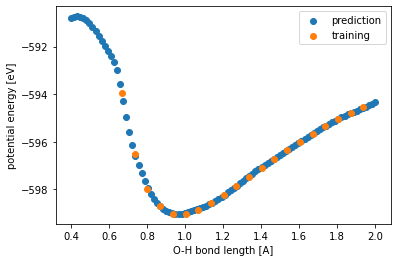

In [15]:
plt.scatter(distances, predictions["energy"], label="prediction")
plt.scatter(distances_training, energies_training, label="training")
plt.xlabel("O-H bond length [A]")
plt.ylabel("potential energy [eV]")
plt.legend()